# Analyse de données financières : Détection d'anomalies dans un porteuille d'actifs

In [1]:
import quandl
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn
from sklearn.ensemble import IsolationForest
from sklearn.neighbors.kde import KernelDensity

# instruction pour plotter dans notebook
%matplotlib inline

# connection à quandl via l'api key
# quandl.ApiConfig.api_key = " 3CipYF1Y3fzjvDgg7E2n"

In [2]:
# Lecture des données
# df = pd.read_csv("all_stocks_5yr.csv", index_col= [0,2],usecols=[0,4,6],parse_dates=[0])
df = pd.read_csv("all_stocks_5yr.csv",usecols=[0,4,6], parse_dates=[0])
df.head()
df.Date = pd.to_datetime(df.Date)
df = df.loc[(df.Date<datetime.datetime(2017, 8, 11,0,0,0)),:]
df = df.loc[df.Date>datetime.datetime(2015, 8, 11,0,0,0),:]
#df =df.dropna(axis=0, how='all').dropna(axis=1, how='any').dropna(axis=0, how='any')
#df.loc[df.Name=='MMM',:]

In [3]:
# df sans index devient un df avec index
# df_mi = df.set_index(['Name','Date'])

In [4]:
# On récupère les donnée sur deux ans, les données principales sont des données sur cinq ans


In [5]:
# on unstack le multi index pour en faire un 
# df_unstack = df_mi.unstack(level=0)
#df_unstack

## Rendements

In [6]:
# fonction de calcul de rendement
# def rends(dff):
#    return dff/dff.diff(1) - 1


In [7]:
# Rendements journaliers obtenue à partit d'un tableau dynamique
df_rendements = df.pivot('Date', 'Name', 'Close').pct_change() #.reset_index(level=[0]).set_index(['Date'])

In [8]:
# fontion de calcul de moyenne mobile sur le rendement
def rends_moov(dff):
    return dff.rolling(window =40).mean()

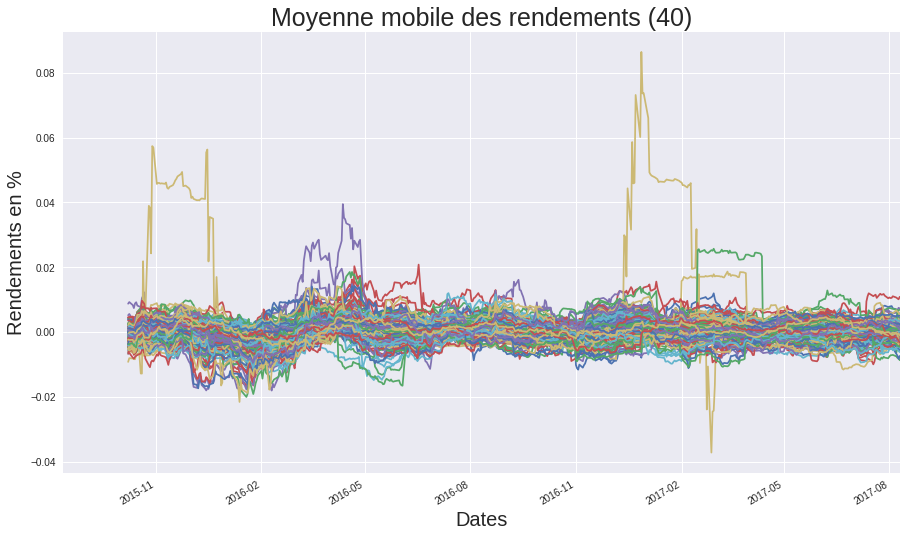

In [41]:
# Calculate the moving average sur les rendements
df_moving_rendements = df_rendements.apply(rends_moov)
df_moving_rendements.plot(figsize=(15,9), legend=False, title="Moyenne mobile des rendements (40)")
plt.ylabel("Rendements en %", size=20)
plt.title('Moyenne mobile des rendements (40)', size=25)
plt.xlabel("Dates",size=20)

## Volatilités

In [10]:
#fonction de calcul des volatilités sur une période
def volts(dff):
    return dff.rolling(40).std() * np.sqrt(40) 

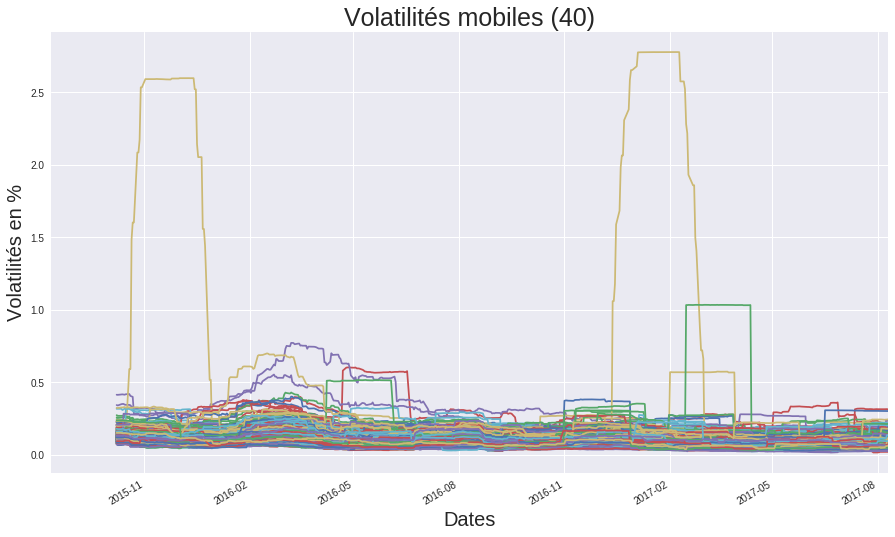

In [42]:
# Define the minumum of periods to consider 
# min_periods = 75
df_moving_volts = df_rendements.apply(volts)
df_moving_volts.plot(figsize=(15,9), legend=False, title="Volatilités mobiles (40)")
plt.ylabel("Volatilités en %", size=20)
plt.title('Volatilités mobiles (40)', size=25)
plt.xlabel("Dates",size=20)

# Detection d'anomalies

# Détection sur les rendements

In [12]:
# df_2 est de dataframe qui contient les données dont on doit détecter les anomalies
# Applications de l'isolation forest sur les données de rendements ou de volatilités
clf = IsolationForest(n_estimators=100, max_samples='auto')

# fit de l'estimateur
clf.fit(df_moving_rendements.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any'))

# the anomaly score of the input samples. the lower the more abnormal.
scores_pred = pd.DataFrame(clf.decision_function(df_moving_rendements.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any')),index=df_moving_rendements.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any').index.values)

predictions = pd.DataFrame(clf.predict(df_moving_rendements.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any')), index=df_moving_rendements.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any').index.values)

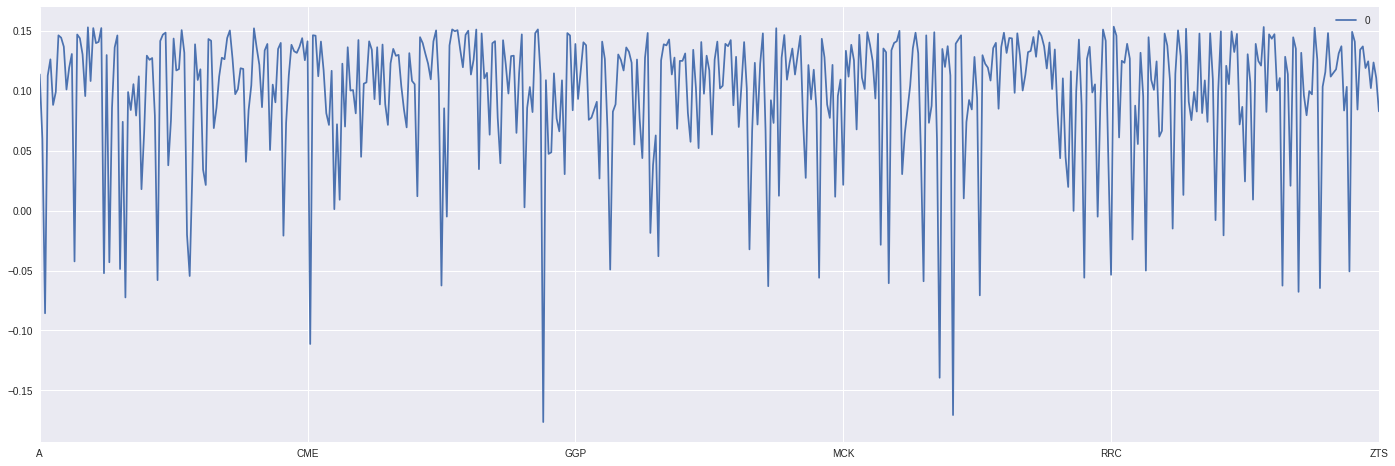

In [13]:
# Les scores de tous les individus
scores_pred.plot(figsize=(24,8))

In [14]:
# Les anomalies prédits ou détectées par le modèle
predictions[predictions==-1].dropna().transpose().columns

Index(['AAP', 'ADSK', 'AKAM', 'ALGN', 'ALXN', 'AMD', 'ANDV', 'APC', 'AYI',
       'AZO', 'CHK', 'CMG', 'COO', 'COST', 'DLTR', 'DVN', 'EA', 'FCX', 'FL',
       'GWW', 'HP', 'HRB', 'KIM', 'KR', 'LB', 'M', 'MAT', 'MOS', 'MRO', 'NFX',
       'NRG', 'NVDA', 'NYSE:NBL', 'ORLY', 'PYPL', 'QRVO', 'REGN', 'RL', 'RRC',
       'SIG', 'SNI', 'STX', 'SYF', 'TRIP', 'TSCO', 'ULTA', 'VIAB', 'VNO',
       'VRTX', 'WFM', 'XEC'],
      dtype='object')

In [15]:
# le score des anomalies
scores_pred.loc[predictions[predictions==-1].dropna().transpose().columns,:].transpose()

,AAP,ADSK,AKAM,ALGN,ALXN,AMD,ANDV,APC,AYI,AZO,...,STX,SYF,TRIP,TSCO,ULTA,VIAB,VNO,VRTX,WFM,XEC
0,-0.085622,-0.042316,-0.052174,-0.043043,-0.048665,-0.072407,0.01798,-0.057954,-0.020033,-0.054505,...,-0.0149,0.01319,-0.007833,-0.020562,0.009282,-0.062554,0.020834,-0.067731,-0.064589,-0.050684


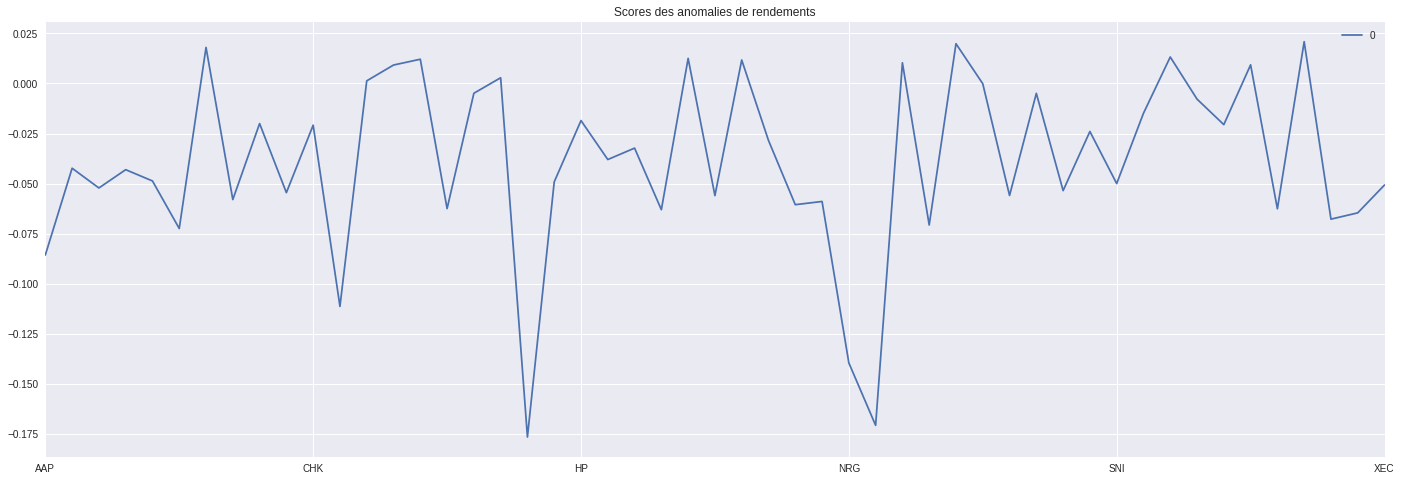

In [16]:
# le score des anomalies
scores_pred.loc[predictions[predictions==-1].dropna().transpose().columns,:].plot(figsize=(24,8), title='Scores des anomalies de rendements')

# Détection sur les volatilités

In [17]:
# df_2 est de dataframe qui contient les données dont on doit détecter les anomalies
# Applications de l'isolation forest sur les données de rendements ou de volatilités
clf = IsolationForest(n_estimators=100, max_samples='auto')

# fit de l'estimateur
clf.fit(df_moving_volts.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any'))

# the anomaly score of the input samples. the lower the more abnormal.
scores_pred2 = pd.DataFrame(clf.decision_function(df_moving_volts.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any')),index=df_moving_volts.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any').index.values)

# 
predictions2 = pd.DataFrame(clf.predict(df_moving_volts.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any')), index=df_moving_volts.transpose().dropna(axis=0, how='all').dropna(axis=1, how='any').index.values)

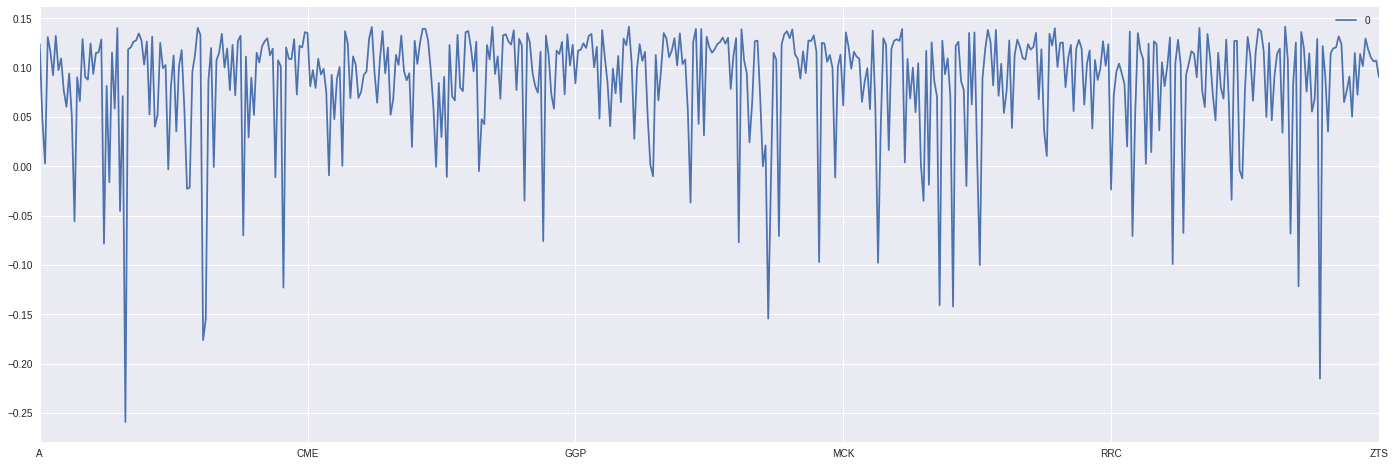

In [18]:
# Les scores de tous les individus
scores_pred2.plot(figsize=(24,8))

In [19]:
# Les anomalies prédits ou détectées par le modèle
predictions2[predictions2==-1].dropna().transpose().columns

Index(['AAP', 'ADSK', 'AKAM', 'ALGN', 'ALXN', 'AMD', 'ARNC', 'AYI', 'AZO',
       'BBY', 'BCR', 'BF.B', 'CA', 'CF', 'CHK', 'COH', 'COTY', 'DUK', 'EA',
       'EQT', 'FCX', 'FL', 'HP', 'HPE', 'INCY', 'JWN', 'KO', 'KR', 'KSS', 'LB',
       'M', 'MAT', 'MON', 'NFLX', 'NFX', 'NKE', 'NRG', 'NVDA', 'NYSE:NWL',
       'ORLY', 'RRC', 'SIG', 'SNI', 'STX', 'SYF', 'TWX', 'UA', 'UAA', 'VNO',
       'VRTX', 'WFM'],
      dtype='object')

In [20]:
# le score des anomalies
scores_pred2.loc[predictions2[predictions2==-1].dropna().transpose().columns,:].transpose()

,AAP,ADSK,AKAM,ALGN,ALXN,AMD,ARNC,AYI,AZO,BBY,...,SIG,SNI,STX,SYF,TWX,UA,UAA,VNO,VRTX,WFM
0,0.002807,-0.055643,-0.07828,-0.016063,-0.045278,-0.258937,-0.003039,-0.022705,-0.021589,-0.176012,...,-0.070481,0.00266,-0.09896,-0.067445,-0.033885,-0.003995,-0.012095,-0.068077,-0.121485,-0.214895


In [21]:
# Graphique des scores des anomalies

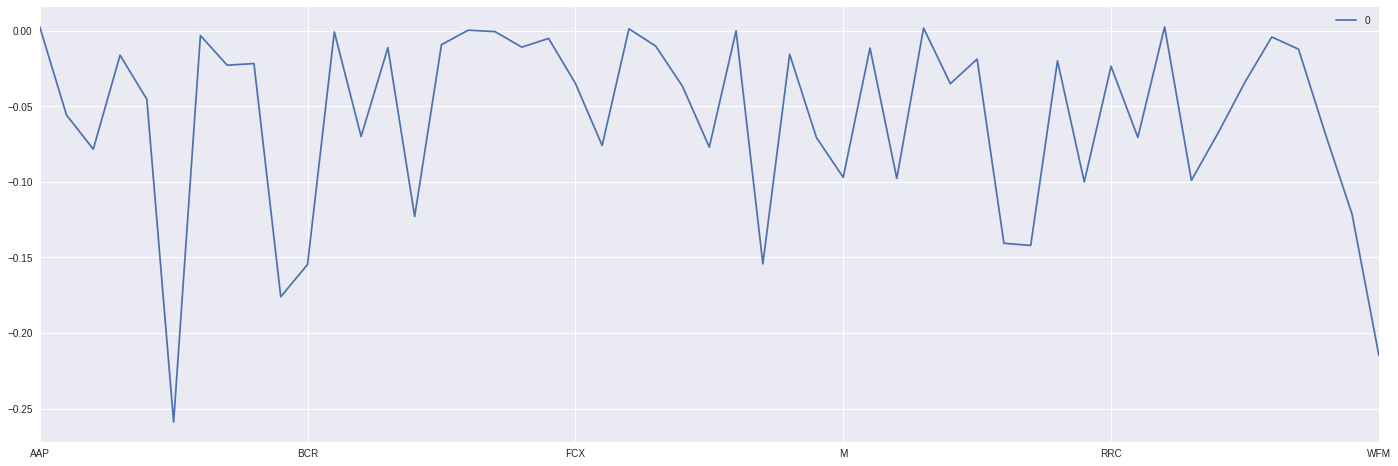

In [22]:
scores_pred2.loc[predictions2[predictions2==-1].dropna().transpose().columns,:].plot(figsize=(24,8))

In [23]:
# comparaison anomalies obetues selon le rendements vs selon la volatilité afin de comparer quelle sont détectées dans les deux cas
predictions2[predictions2==-1].dropna().transpose().columns.sort_values()==predictions[predictions==-1].dropna().transpose().columns.sort_values()

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False], dtype=bool)

# Détection sur la fonction de densité

In [82]:
# fonction d'estimation des fonction de densités des rendements des actifs
def fdensite(X):
    X_plot = np.linspace(-3, 3, 504)[:, np.newaxis]
    a = (KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X.values))
    a = a.score_samples(X_plot)
    return (a)

In [83]:
#df_densites = pd.DataFrame(df_rendements).apply(fdensite)
#df_rendements.dropna().apply(fdensite, axis = 1)
# df_rendements.drop('XL', axis=1).reset_index(drop=True).dropna(how = 'any').apply(fdensite, axis = 1)

/home/work/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: ('query data dimension must match training data dimension', 'occurred at index 486')

In [ ]:
#df_densites.to_csv('df_densite.csv')

df_densites['X'] = np.linspace(-3, 3, 100)[:, np.newaxis]
df_densites.plot(figsize=(24,10), title='Distribution des rendements', fontsize=15, legend=False, x = 'X')
plt.ylabel("probabilités",size=20)
plt.title('Distributions des rendements', size=25)
plt.xlabel("valeurs de rendements",size=20)#np.linspace(-5, 10, 504)[:, np.newaxis]

/home/work/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/work/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


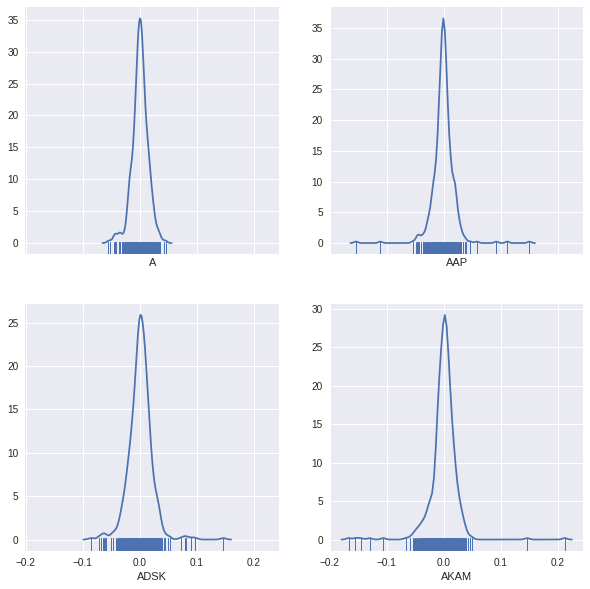

In [95]:
import seaborn as sns

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
sns.despine(left=True)

sns.distplot(df_rendements.A, hist=False, rug=True,kde=True,  ax=axes[0, 0])

sns.distplot(df_rendements.AAP, hist=False, rug=True,kde=True,  ax=axes[0, 1])

sns.distplot(df_rendements.ADSK, hist=False, rug=True,kde=True,  ax=axes[1, 0])

sns.distplot(df_rendements.AKAM, hist=False, rug=True,kde=True,  ax=axes[1, 1])


In [27]:
# df_2 est de dataframe qui contient les données dont on doit détecter les anomalies
# Applications de l'isolation forest sur les données de rendements ou de volatilités
clf = IsolationForest(n_estimators=100, max_samples='auto')

# fit de l'estimateur
clf.fit(df_densites.transpose())

# the anomaly score of the input samples. the lower the more abnormal.
scores_pred3 = pd.DataFrame(clf.decision_function(df_densites.transpose()),index=df_densites.transpose().index.values)

# 
predictions3 = pd.DataFrame(clf.predict(df_densites.transpose()), index=df_densites.transpose().index.values)

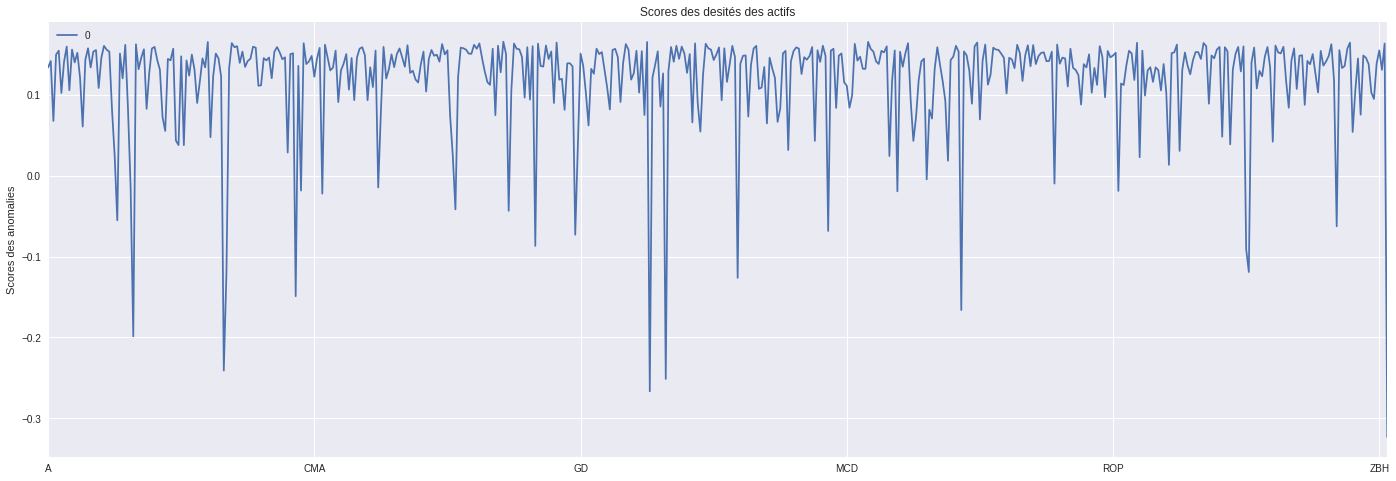

In [28]:
# Les scores de tous les individus
scores_pred3.plot(figsize=(24,8), title='Scores des desités des actifs')
plt.ylabel("Scores des anomalies")

In [29]:
# Les anomalies prédites ou détectées par le modèle
predictions3[predictions3==-1].dropna().transpose().columns

Index(['ADSK', 'ALB', 'ALGN', 'AMAT', 'AMD', 'APC', 'ARNC', 'ATVI', 'AVGO',
       'BBY', 'BHF', 'BHGE', 'CF', 'CHK', 'CHTR', 'CMG', 'CTXS', 'DVN', 'DXC',
       'EVHC', 'FCX', 'FTI', 'FTV', 'GILD', 'HLT', 'HPQ', 'INCY', 'JEC', 'KMI',
       'LB', 'LRCX', 'M', 'MOS', 'MRO', 'MU', 'NEM', 'NRG', 'NVDA', 'PRGO',
       'RRC', 'SIG', 'SRCL', 'STX', 'TRIP', 'TSCO', 'UA', 'UAA', 'URI', 'WMB',
       'WYNN', 'X'],
      dtype='object')

In [30]:
# le score des anomalies
scores_pred3.loc[predictions3[predictions3==-1].dropna().transpose().columns,:].transpose()

,ADSK,ALB,ALGN,AMAT,AMD,APC,ARNC,ATVI,AVGO,BBY,...,SRCL,STX,TRIP,TSCO,UA,UAA,URI,WMB,WYNN,X
0,0.060865,0.02542,-0.055074,-0.01341,-0.19862,0.055432,0.043607,0.037973,0.037882,0.047726,...,0.013521,0.030733,0.048292,0.038889,-0.090804,-0.119111,0.042167,-0.062538,0.054202,-0.323201


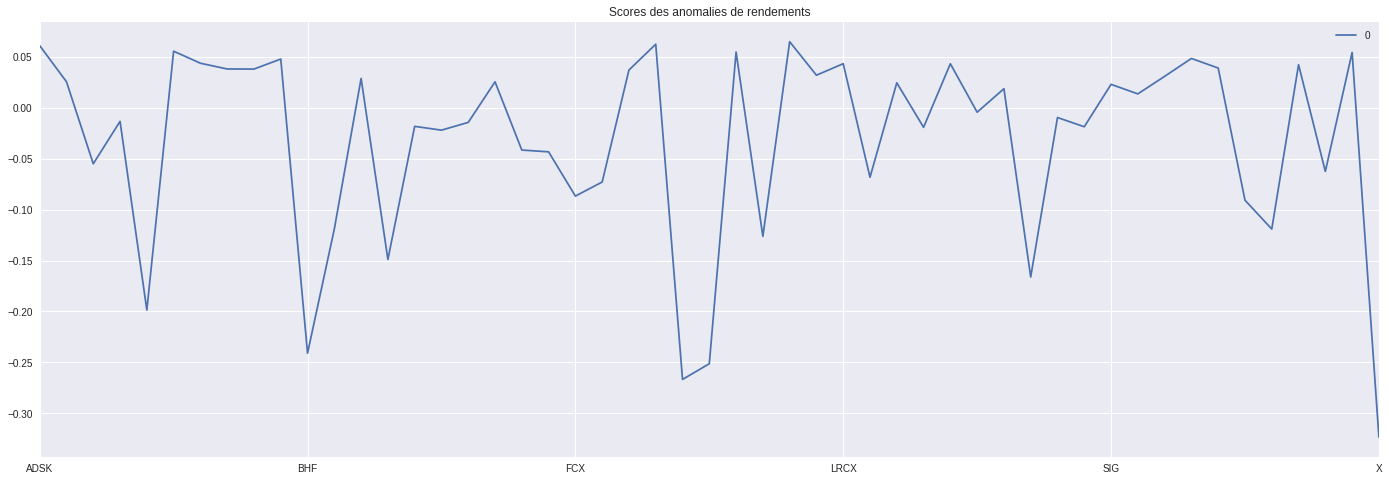

In [31]:
# le score des anomalies
scores_pred3.loc[predictions3[predictions3==-1].dropna().transpose().columns,:].plot(figsize=(24,8), title='Scores des anomalies de rendements')

# Nielson siegel svensson détection sur densité

In [32]:
#a = df_rendements.A.reset_index().A.sort_values().reset_index().A.to_csv('nss_data.csv')
a= pd.read_csv("sols.csv", index_col=0)

In [33]:
a.head()

,V1,V2,V3,V4,V5,V6
A,0.074582,29.916334,-29.999920,-0.034166,0.097919,5.0
AAL,0.074639,29.265639,-29.429360,-0.034725,0.045010,5.0
AAP,0.074583,29.916275,-29.999859,-0.034171,0.097909,5.0
AAPL,0.074639,28.937917,-29.148916,-0.034724,0.034924,5.0
ABBV,0.074583,29.794237,-29.877787,-0.034170,0.097941,5.0


In [34]:
# df_2 est de dataframe qui contient les données dont on doit détecter les anomalies
# Applications de l'isolation forest sur les données de rendements ou de volatilités
clf = IsolationForest(n_estimators=100, max_samples='auto')

# fit de l'estimateur
clf.fit(a)

# the anomaly score of the input samples. the lower the more abnormal.
scores_pred4 = pd.DataFrame(clf.decision_function(a),index=a.index.values)

# 
predictions4 = pd.DataFrame(clf.predict(a), index=a.index.values)

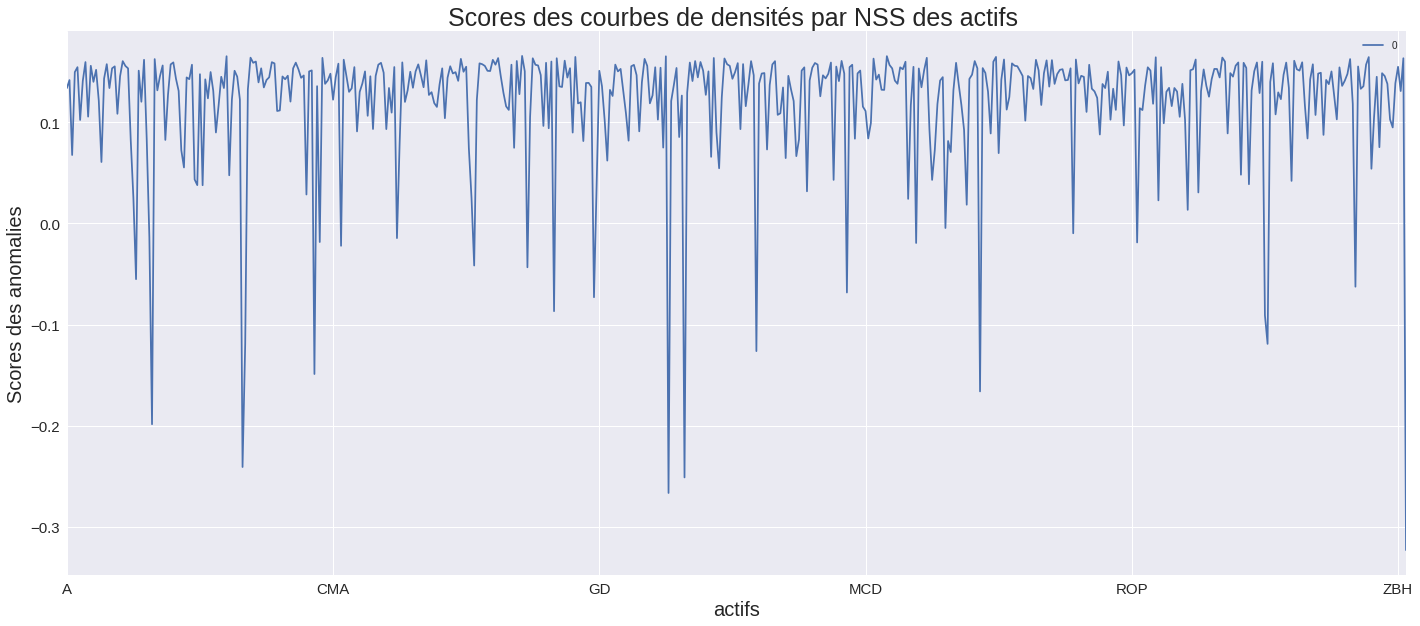

In [35]:
# Les scores de tous les individus
scores_pred3.plot(figsize=(24,10), title='Scores des courbes de densités par NSS des actifs ', fontsize=15)
plt.ylabel("Scores des anomalies",size=20)
plt.title('Scores des courbes de densités par NSS des actifs ', size=25)
plt.xlabel("actifs",size=20)

In [36]:
# Les anomalies prédites ou détectées par le modèle
predictions4[predictions4==-1].dropna().transpose().columns

Index(['ADM', 'AFL', 'ALL', 'APC', 'APD', 'AVGO', 'BHF', 'BHGE', 'BK', 'BMY',
       'CA', 'CB', 'CHK', 'CME', 'CSX', 'DRE', 'DVN', 'ETN', 'EXC', 'FISV',
       'FOXA', 'GILD', 'GRMN', 'HLT', 'JNJ', 'KSU', 'LB', 'LEG', 'M', 'MDT',
       'MNST', 'MRO', 'NOC', 'OKE', 'ORLY', 'PAYX', 'PFE', 'PSX', 'RRC', 'SNA',
       'TRIP', 'TROW', 'VMC', 'VTR', 'WMB', 'WMT', 'WYNN', 'XLNX', 'YUM',
       'ZBH', 'ZION'],
      dtype='object')

In [37]:
predictions3[predictions3==-1].dropna().transpose().columns

Index(['ADSK', 'ALB', 'ALGN', 'AMAT', 'AMD', 'APC', 'ARNC', 'ATVI', 'AVGO',
       'BBY', 'BHF', 'BHGE', 'CF', 'CHK', 'CHTR', 'CMG', 'CTXS', 'DVN', 'DXC',
       'EVHC', 'FCX', 'FTI', 'FTV', 'GILD', 'HLT', 'HPQ', 'INCY', 'JEC', 'KMI',
       'LB', 'LRCX', 'M', 'MOS', 'MRO', 'MU', 'NEM', 'NRG', 'NVDA', 'PRGO',
       'RRC', 'SIG', 'SRCL', 'STX', 'TRIP', 'TSCO', 'UA', 'UAA', 'URI', 'WMB',
       'WYNN', 'X'],
      dtype='object')